# Project 5: The Enron Dataset

Robert Lee

## The Data Set & Outliers
There are 146 people in the Enron Dataset, 21 features each, 18 POI (persons of interest).
A tossed out three data points as being unusual artifacts. I did not throw out outliers because they generally seemed to have useful infomration to identify POIs.

## Feature Selection & Engineering
I selected 7 features from the original dataset, and created 3 new ones. Looking at correlation to the POI label (from the correlation matrix below), it seems that my new features are not particularly useful for classification. And in fact, 3-5 of best (selectKbest) of the original 7 features seem to be good enough to do the job. If I were to spend more time on this project I would engineer additional features and determine what would be the smallest number of features that would yield good results. Since there was not a huge number of features, I did not do PCA.

##  Training & Testing Classifiers
As a starting point, I tried NB, DTC, KNN classifiers a few times using different test sizes. NB worked OK, DTC did not, KNN worked well. So I fcoused on KNN for in my grid search. I ran gridSearchCSV with 10, 5, 3, and 1 features with test sizes of 0.3 and 0.1. Of these 10 searches, 5 resulted in classifier 1 and 5 resulted in classifier 2. Classifier 1 had a better F1 score (0.45 vs. 0.37) so I called this my best classifier and wrote it to the pkl file.

For reasons discussed here, it seems like it isn't a good idea to use a pipeline to search through a range of selectKbest features:
https://discussions.udacity.com/t/selectkbest-pca-and-pipelines/22986/9

I suppose I could have written a loop to try to the entire range, but I just picked 10, 5, 3, 1 features as stated above.

gridSearchCSV()
param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }
             
Classifier 1
KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')        
F1 = 0.45

Classifier 2
KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')        
F1 = 0.37

***

I also ran AdaBoost using NB and DTC as the base classifiers (KNN is incompatible with AdaBoost). The resulting classifiers had lower F1 scores than Classifier 1, so I stuck with that one.

DTC = DecisionTreeClassifier(random_state = 42, max_features = "auto", class_weight = "balanced",max_depth = None)
ada = AdaBoostClassifier(base_estimator=DTC)

param_grid = {"ada__base_estimator__criterion" : ["gini", "entropy"],
              "ada__base_estimator__splitter" :   ["best", "random"],
              "ada__n_estimators": [1, 10, 50, 100, 200]
             }

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impur...dom_state=42, splitter='random'),
          learning_rate=1.0, n_estimators=10, random_state=None))])
           {'ada__base_estimator__splitter': 'random',
           'ada__n_estimators':10'ada__base_estimator__criterion': 'entropy'}
F1 = 0.32

***

NB = GaussianNB()
adaN = AdaBoostClassifier(base_estimator=NB)

param_grid = {
              "ada__n_estimators": [1, 10, 50, 100, 200]
             }

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=GaussianNB(priors=None), learning_rate=1.0,
          n_estimators=1, random_state=None))])
          {'ada__n_estimators': 1}
          
F1 = 0.25

## Tuning & Validation

By choosing different classifiers and trying parameters, it is possible to get a classifier that works really well (has very high scores) on the test data. This is called tuning, and is part of the art of machine learning. A classifier out of the box may not do a good job of correctly labeling data, but with paramter turning we can improve this.

But if we try to optimize too much, we can be guilty of overfitting (overtuning). In fact we could manually create a classifier that perfectly fits the training data with an absurd amount of overfit. Because of possible idiosyncracies and outliers in the training data, it is important to consider possible overfitting.

After fitting the classifier on training data, we test (or validate) it with test data before releasing it into the real world. It is a fairly easy thing, with overtuning, to create a classifier that works very well on the training data. But if we don't test the classifer on other data, we may have built a pretty, but useless, classifier. Among other things, outliers in the training data in can skew the classifier fit. Outliers in the testing data can skew the validations scores.

Validation can be a bit tricky if there is a limited data, because we don't have much data to train on, much less allocate as between training and test data. This is definitely true of our data set, with only 143 people and 18 POIs). A large number of features relative to the number of data points can be a problem as well, though we can address this to some degree with PCA.

Cross validation techniques help us avoid this, by radomly distributing and redistributing data between training and test, we can avoid classifier training problems such as overfitting.

I used StratifiedShuffleSplit() with 100 splits. This means that there were 100 randomized train-test splits. The shuffling balances data between training and testing. It also randomzies data that might be ordered. I also could also have used .KFold, but the random shuffling of StratifiedShuffleSplit() is useful because of our small data set.

Stratification is the process of distributing class labels relatively evenly between testing and training to prevent bias in either. StratifiedShuffleSplit() and StratifiedKFold() do this for us.

## Precision & Recall
Since the label is POI:

precision = POI true positives / (POI true positives + POI false positives)

recall = POI true positives / (POI true positives + POI false negatives)

Thus if our classifier identified 10 POIs, with 5 true positives and 5 false positives, precision would be 0.5

If the ground state truth was 12 POIs, where we correctly identified 5 but 7 were false negatives, our recall also would be 0.42

F1 is a score that balances precision against recall
F1 = 2 (precision * recall) / precision + recall

In the above example F1 = 0.46

Sometimes we don't want to balance them in this way, in that the consequences of a false positive vs false negative are asymmetric. We might want a higher precision at the expense of recall or vice versa.

In [1]:
#!/usr/bin/python

import sys
import pickle

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import grid_search 
from time import time

from sklearn import svm, cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from tester import test_classifier
import numpy as np
import pandas as pd

from sklearn.ensemble import AdaBoostClassifier

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']
# You will need to use more features, 8 existing features, 3 new ones I created

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

import pprint

/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

I use 8 existing features, and create 3 more (the last 3), combining them to create a list of 11 features. The first feature is the label, poi, so really there are just 10 features in play.

features_old = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi']

features_new = ['ratio_to_poi','ratio_from_poi','ratio_exercised']

features_list = features_old + features_new

In [2]:
features_old = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages']
features_new = ['poi','ratio_to_poi','ratio_from_poi','ratio_exercised']
features_list = features_old + features_new
features_list.pop(8)
features_list

['poi',
 'salary',
 'total_stock_value',
 'exercised_stock_options',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'from_messages',
 'to_messages',
 'ratio_to_poi',
 'ratio_from_poi',
 'ratio_exercised']

Here is one entry in the dictionary, key: 'ALLEN PHILLIP K'

In [3]:
pprint.pprint(data_dict['ALLEN PHILLIP K'])

{'bonus': 4175000,
 'deferral_payments': 2869717,
 'deferred_income': -3081055,
 'director_fees': 'NaN',
 'email_address': 'phillip.allen@enron.com',
 'exercised_stock_options': 1729541,
 'expenses': 13868,
 'from_messages': 2195,
 'from_poi_to_this_person': 47,
 'from_this_person_to_poi': 65,
 'loan_advances': 'NaN',
 'long_term_incentive': 304805,
 'other': 152,
 'poi': False,
 'restricted_stock': 126027,
 'restricted_stock_deferred': -126027,
 'salary': 201955,
 'shared_receipt_with_poi': 1407,
 'to_messages': 2902,
 'total_payments': 4484442,
 'total_stock_value': 1729541}


Length of dictionary (number of people) and length of one of the entries == # of features

In [4]:
print len(data_dict)
print len(data_dict['ALLEN PHILLIP K'])

146
21


### Task 2: Remove outliers

Three of the "people" in the dictionary are not people, but bad data to be removed

"TOTAL" appears to be a summary statistic.
"TRAVEL AGENCY IN THE PARK" appears to be a contractor that was paid a sum of money.
"LOCKHART EUGENE E" has all NaN values. Harmless, but I go ahead and remove it.

I don't remove data outliers, because they are probably important data (the big shot executives making a lot of money and communicating a lot with each other).

In [5]:
data_dict.pop('TOTAL', 0)
data_dict.pop('TRAVEL AGENCY IN THE PAR', 0)
data_dict.pop('LOCKHART EUGENE E', 0)
print "Three entries popped"
len(data_dict)

Three entries popped


144

### I look for 'poi = TRUE to count the number of persons of interest

In [6]:
n=0
for each in data_dict:
    if data_dict[each]['poi']:
        n+=1
print n

18


### Task 3: Create new feature(s)
The 3 new features I create are:
ratio_exercised, ratio_to_poi, ratio_from_poi

(1) ratio_exercised = exercised_stock_options / total_stock_value
I created this feature to reflect how much stock the person exercised out of their total (from 0 to 1). I figured that people who were in on the scam might have exercised more of their options, knowing that it was a house of cards. On the other hand, a middle-class person who was not in on the scam might also exercise their options, given the high share price (honest desire to cash in).

(2) ratio_to_poi = from_this_person_to_poi / to_messages
Another 0 to 1 ratio. The absolute number of emails to a POI is less meaningful than the ratio of their messages to POI.

(3) ratio_to_poi = from_poi_to_this_person / from_messages
Another 0 to 1 ratio. The absolute number of emails from a POI is less meaningful than the ratio of messages from a POI.

I am aware that there might be data leakage issues regarding from_this_person_to_poi and from_poi_to_this_person, and thus any features derived from them, but it is not abssolutely clear that this is the case, so I will accept that they are OK features to use for purposes of this assignment.

I first eliminate NaN and bad values (any of numerator < 0, any denominator <= 0)

In [7]:
def new_feature(numerator,denominator):
    new_feature=[]

    for i in data_dict:
        if data_dict[i][numerator]=="NaN" or data_dict[i][denominator]=="NaN":
            new_feature.append("NaN")
        elif data_dict[i][numerator]<0 or data_dict[i][denominator]<=0:
            new_feature.append("NaN")
        else:
            new_feature.append(float(data_dict[i][numerator]) / data_dict[i][denominator])
    return new_feature

### create lists of new features
ratio_exercised=new_feature("exercised_stock_options","total_stock_value")
ratio_to_poi=new_feature("from_poi_to_this_person","to_messages")
ratio_from_poi=new_feature("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["ratio_exercised"] = ratio_exercised[count]
    data_dict[i]["ratio_to_poi"] = ratio_to_poi[count]
    data_dict[i]["ratio_from_poi"] = ratio_from_poi[count]
    count +=1

### store to my_dataset for easy export below
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

labels, features = targetFeatureSplit(data)

In [8]:
data = featureFormat(my_dataset, features_list, sort_keys = True)

labels, features = targetFeatureSplit(data)

# Plot new features to get a feel for them
## ratio_exercised

Ratio of stock options exercised is betwen 0 (none exercised) up to about 20%

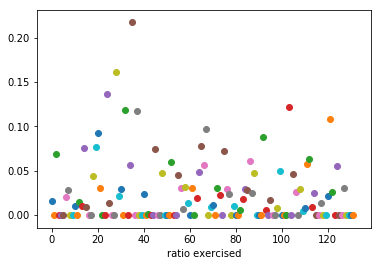

In [9]:
n=0
for point in data:
    ratio_exercised = point[8]
    plt.scatter( n, ratio_exercised )
    n+=1
plt.xlabel("ratio exercised")
plt.show()

## ratio_to_poi

Ratio of all emails sent to POI

Between 0 and 1.0.

The one 1.0 data point is suspiciously high, so I print one that point above the plot. This person was not a PIO, had a salary of 130K, had significant stock, sent 10 emails to POI, received 17 emails from POI, sent 17 total emails, and received 128 total emails. So this data point does not seem outlanding. In addition, since this feature is not in my top 5 best (see below), I am not too concerned with this 1.0 value.

[  0.00000000e+00   1.30724000e+05   2.28276800e+06   2.28276800e+06
   1.00000000e+01   1.70000000e+01   1.70000000e+01   1.28000000e+02
   7.81250000e-02   1.00000000e+00   1.00000000e+00]


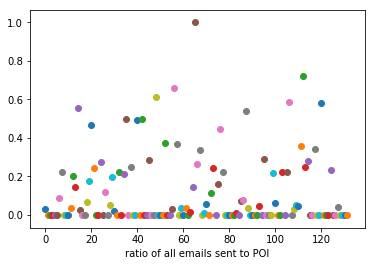

In [10]:
n=0
for point in data:
    ratio_to_poi  = point[9]
    if ratio_to_poi == 1.0:
        print point
    plt.scatter( n, ratio_to_poi )
    n+=1
plt.xlabel("ratio of all emails sent to POI")
plt.show()

## ratio_from_poi

Ratio of all emails from POI

Between 0 and 1.0.

There are a lot of 1.0 data points. So either the data is generally pretty bad, or else these 1.0 values are valid. I'll go with the latter assumption, though of course I could investigate more.

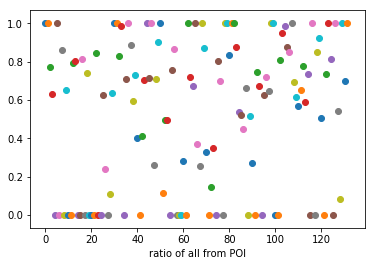

In [11]:
n=0
for point in data:
    ratio_from_poi  = point[10]
    plt.scatter( n, ratio_from_poi )
    n+=1
plt.xlabel("ratio of all from POI")
plt.show()

## I print a correlation matrix to get a sense of feature correlation with the labels (row/column 0)

Of the 3 new features, 8,9,10, only 9, ratio_from_poi has a fairly strong correlation, 0.31. Thus one could argue that is the only new feature worth looking at. But for sake of academic exercise, rather than trying to engineer additional new features, I'll continue with these.

Of the original 7 features, 1,2,3 all have correlations to the label above 0.3. These are the 3 best features, and 9, above, is the forth best. None of the other features are even close in terms of correlation. Thus one could argue that we should only use these 3 or 4 features.

Not surprisingly, the first three features, all related to money, are highly correlated to each other with 2 and 3 being correlated at 0.96. Thus 2 and 3 in particular would be amendable to PCA to reduce the number of features. For the scope of this project, though, PCA didn't seem necessary, as we are already working with a small number of features, so I did not do PCA.

1 salary
2 total_stock_value
3 exercised_stock_options
9 ratio_from_poi

In [12]:
n=0
for feature in features_list:
    print n,feature
    n+=1
    
df = pd.DataFrame(data)
df.corr()
#for each in np.corrcoef(data):
 #   print each

0 poi
1 salary
2 total_stock_value
3 exercised_stock_options
4 from_poi_to_this_person
5 from_this_person_to_poi
6 from_messages
7 to_messages
8 ratio_to_poi
9 ratio_from_poi
10 ratio_exercised


0         1         2         3         4         5         6   \
0   1.000000  0.323062  0.373375  0.378329  0.175804  0.120282 -0.043027   
1   0.323062  1.000000  0.507512  0.434179  0.382845  0.188981  0.128107   
2   0.373375  0.507512  1.000000  0.963300  0.118218  0.008916 -0.022347   
3   0.378329  0.434179  0.963300  1.000000  0.107552 -0.009687 -0.033640   
4   0.175804  0.382845  0.118218  0.107552  1.000000  0.491520  0.245550   
5   0.120282  0.188981  0.008916 -0.009687  0.491520  1.000000  0.606896   
6  -0.043027  0.128107 -0.022347 -0.033640  0.245550  0.606896  1.000000   
7   0.091524  0.369150  0.097094  0.065464  0.608153  0.600738  0.504045   
8   0.130400  0.214900 -0.008048 -0.000078  0.571588  0.070609 -0.018426   
9   0.310498  0.271439  0.101619  0.088343  0.237443  0.069135 -0.072205   
10 -0.063065 -0.020504  0.212430  0.290629  0.006517 -0.007351  0.047233   

          7         8         9         10  
0   0.091524  0.130400  0.310498 -0.063065  
1   0.369150  0.214900  0.271439 -0.020504  
2   0.097094 -0.008048  0.101619  0.212430  
3   0.065464 -0.000078  0.088343  0.290629  
4   0.608153  0.571588  0.237443  0.006517  
5   0.600738  0.070609  0.069135 -0.007351  
6   0.504045 -0.018426 -0.072205  0.047233  
7   1.000000  0.103680  0.096925 -0.013960  
8   0.103680  1.000000  0.470755 -0.052790  
9   0.096925  0.470755  1.000000  0.005317  
10 -0.013960 -0.052790  0.005317  1.000000

# Trying out a few classifiers
Rather than use systematic cross-validation and classifier search with gridSearchCSV, for now I simply try some classifiers on three sizes, just to get a feel: 0.1, 0.3, 0.5

features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=X, random_state=42)

Since there are only 18 POIs, we can only go so small with the test size before we don't get any POIs. 0.1 is probably about the smallest we can use.

In [13]:
features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

# Trying NB with the above features and test sizes

In [14]:
def classify_NB(features_train, labels_train):
    
    ### your code goes here--should return a trained decision tree classifer
    
    clf = GaussianNB()
    clf.fit(features_train, labels_train)
    return clf

def class_run(features_train, labels_train, features_test, labels_test):
    clf = classify_NB(features_train, labels_train)
    pred = clf.predict(features_test)
    return {"Accuracy":accuracy_score(pred,labels_test),\
                          "Precision":precision_score(pred,labels_test),\
                          "Recall":recall_score(pred,labels_test),\
                          "F1":f1_score(pred,labels_test)}

In [15]:
print "all 10 features (plus poi label)"
def print_it(title,input):
    print title
    answer = input
    for each in answer:
        print each," : ",answer[each]
    print

print_it("NB: 0.1 test size",class_run(features_train1, labels_train1, features_test1, labels_test1))
print_it("NB: 0.3 test size",class_run(features_train3, labels_train3, features_test3, labels_test3))
print_it("NB: 0.5 test size",class_run(features_train5, labels_train5, features_test5, labels_test5))

all 10 features (plus poi label)
NB: 0.1 test size
Recall  :  0.5
F1  :  0.4
Precision  :  0.333333333333
Accuracy  :  0.785714285714

NB: 0.3 test size
Recall  :  0.75
F1  :  0.6
Precision  :  0.5
Accuracy  :  0.9

NB: 0.5 test size
Recall  :  0.333333333333
F1  :  0.4
Precision  :  0.5
Accuracy  :  0.863636363636



# Trying NB with different subsets of the features

features_list contains all 11 features (8 original, 3 new)

I create these subset feature lists as well

Each must contain the first feature, poi

features_old = poi + the original 7

features_new = poi + the 3 new ones

features_first = poi + 1,2,3   ($ related)

features_second = poi + 4,5,6,7 (email related)

features_F = features_first + 'ratio_exercised' ($ related)

features_E = features_second + ratio_to_poi' + 'ratio_from_poi' (email related)

In [16]:
features_first = ['poi','salary','total_stock_value','exercised_stock_options']
features_second = ['poi','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']
features_F = ['poi','salary','total_stock_value','exercised_stock_options','ratio_exercised']
features_E = ['poi','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi']

## Using the original 7 features yields the same results as using all 10 features

In [17]:
data = featureFormat(my_dataset, features_old, sort_keys = True)

labels, features_o = targetFeatureSplit(data)
features_train1o, features_test1o, labels_train1o, labels_test1o = cross_validation.train_test_split(features_o, labels, test_size=0.1, random_state=42)
features_train3o, features_test3o, labels_train3o, labels_test3o = cross_validation.train_test_split(features_o, labels, test_size=0.3, random_state=42)
features_train5o, features_test5o, labels_train5o, labels_test5o = cross_validation.train_test_split(features_o, labels, test_size=0.5, random_state=42)

print "features_old = the original 7"
print
print_it("NB: 0.1 test size",class_run(features_train1o, labels_train1o, features_test1o, labels_test1o))
print_it("NB: 0.3 test size",class_run(features_train3o, labels_train3o, features_test3o, labels_test3o))
print_it("NB: 0.5 test size",class_run(features_train5o, labels_train5o, features_test5o, labels_test5o))

features_old = the original 7

NB: 0.1 test size
Recall  :  0.5
F1  :  0.4
Precision  :  0.333333333333
Accuracy  :  0.785714285714

NB: 0.3 test size
Recall  :  0.75
F1  :  0.6
Precision  :  0.5
Accuracy  :  0.9

NB: 0.5 test size
Recall  :  0.333333333333
F1  :  0.4
Precision  :  0.5
Accuracy  :  0.863636363636



## Using just the 3 new features doesn't work as well

In [18]:
data_n = featureFormat(my_dataset, features_new, sort_keys = True)
labels, features_n = targetFeatureSplit(data_n)
features_train1n, features_test1n, labels_train1n, labels_test1n = cross_validation.train_test_split(features_n, labels, test_size=0.1, random_state=42)
features_train3n, features_test3n, labels_train3n, labels_test3n = cross_validation.train_test_split(features_n, labels, test_size=0.3, random_state=42)
features_train5n, features_test5n, labels_train5n, labels_test5n = cross_validation.train_test_split(features_n, labels, test_size=0.5, random_state=42)

print "features_new = poi + 3 new features"
print
print_it("NB: 0.1 test size",class_run(features_train1n, labels_train1n, features_test1n, labels_test1n))
print_it("NB: 0.3 test size",class_run(features_train3n, labels_train3n, features_test3n, labels_test3n))
print_it("NB: 0.5 test size",class_run(features_train5n, labels_train5n, features_test5n, labels_test5n))

features_new = poi + 3 new features



/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


NB: 0.1 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.833333333333

NB: 0.3 test size
Recall  :  0.333333333333
F1  :  0.25
Precision  :  0.2
Accuracy  :  0.833333333333

NB: 0.5 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.830508474576



## Neither does using just money related features

In [19]:
data_f = featureFormat(my_dataset, features_first, sort_keys = True)
labels, features_f = targetFeatureSplit(data_f)
features_train1f, features_test1f, labels_train1f, labels_test1f = cross_validation.train_test_split(features_f, labels, test_size=0.1, random_state=42)
features_train3f, features_test3f, labels_train3f, labels_test3f = cross_validation.train_test_split(features_f, labels, test_size=0.3, random_state=42)
features_train5f, features_test5f, labels_train5f, labels_test5f = cross_validation.train_test_split(features_f, labels, test_size=0.5, random_state=42)

print "features_first = poi + 1,2,3   ($ related)"
print
print_it("NB: 0.1 test size",class_run(features_train1f, labels_train1f, features_test1f, labels_test1f))
print_it("NB: 0.3 test size",class_run(features_train3f, labels_train3f, features_test3f, labels_test3f))
print_it("NB: 0.5 test size",class_run(features_train5f, labels_train5f, features_test5f, labels_test5f))

features_first = poi + 1,2,3   ($ related)

NB: 0.1 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.846153846154

NB: 0.3 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.871794871795

NB: 0.5 test size
Recall  :  0.25
F1  :  0.181818181818
Precision  :  0.142857142857
Accuracy  :  0.861538461538



## Nor just email

In [20]:
data_s = featureFormat(my_dataset, features_second, sort_keys = True)
labels, features_s = targetFeatureSplit(data_s)
features_train1s, features_test1s, labels_train1s, labels_test1s = cross_validation.train_test_split(features_s, labels, test_size=0.1, random_state=42)
features_train3s, features_test3s, labels_train3s, labels_test3s = cross_validation.train_test_split(features_s, labels, test_size=0.3, random_state=42)
features_train5s, features_test5s, labels_train5s, labels_test5s = cross_validation.train_test_split(features_s, labels, test_size=0.5, random_state=42)

print "poi + 4,5,6,7 (email related)"
print
print_it("NB: 0.1 test size",class_run(features_train1s, labels_train1s, features_test1s, labels_test1s))
print_it("NB: 0.3 test size",class_run(features_train3s, labels_train3s, features_test3s, labels_test3s))
print_it("NB: 0.5 test size",class_run(features_train5s, labels_train5s, features_test5s, labels_test5s))

poi + 4,5,6,7 (email related)

NB: 0.1 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.833333333333

NB: 0.3 test size
Recall  :  0.272727272727
F1  :  0.352941176471
Precision  :  0.5
Accuracy  :  0.694444444444

NB: 0.5 test size
Recall  :  0.5
F1  :  0.444444444444
Precision  :  0.4
Accuracy  :  0.833333333333



## Now I'll run SelectKBest on k=1 through k=9

In [21]:
acc = []
precision = []
recall = []
f1 = []

for n in range (9,0,-1):
    print "SelectKBest() best features, k =",n
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features_n = targetFeatureSplit(data)
    K_best_n = SelectKBest(k=n)
    features_Kbest_n = K_best_n.fit_transform(features_n, labels)

    features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features_Kbest_n, labels, test_size=0.1, random_state=42)
    features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features_Kbest_n, labels, test_size=0.3, random_state=42)
    features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features_Kbest_n, labels, test_size=0.5, random_state=42)

    print
    ts1 = class_run(features_train1, labels_train1, features_test1, labels_test1)
    ts3 = class_run(features_train3, labels_train3, features_test3, labels_test3)
    ts5 = class_run(features_train5, labels_train5, features_test5, labels_test5)
    
    print_it("NB: 0.1 test size",ts1)
    print_it("NB: 0.3 test size",ts3)
    print_it("NB: 0.5 test size",ts5)
    
    acc.append(ts5["Accuracy"])
    precision.append(ts5["Recall"])
    recall.append(ts5["Precision"])
    f1.append(ts5["F1"])

SelectKBest() best features, k = 9

NB: 0.1 test size
Recall  :  0.5
F1  :  0.4
Precision  :  0.333333333333
Accuracy  :  0.785714285714

NB: 0.3 test size
Recall  :  0.75
F1  :  0.6
Precision  :  0.5
Accuracy  :  0.9

NB: 0.5 test size
Recall  :  0.5
F1  :  0.5
Precision  :  0.5
Accuracy  :  0.909090909091

SelectKBest() best features, k = 8

NB: 0.1 test size
Recall  :  0.5
F1  :  0.4
Precision  :  0.333333333333
Accuracy  :  0.785714285714

NB: 0.3 test size
Recall  :  0.75
F1  :  0.6
Precision  :  0.5
Accuracy  :  0.9

NB: 0.5 test size
Recall  :  0.5
F1  :  0.5
Precision  :  0.5
Accuracy  :  0.909090909091

SelectKBest() best features, k = 7

NB: 0.1 test size
Recall  :  0.5
F1  :  0.4
Precision  :  0.333333333333
Accuracy  :  0.785714285714

NB: 0.3 test size
Recall  :  0.75
F1  :  0.6
Precision  :  0.5
Accuracy  :  0.9

NB: 0.5 test size
Recall  :  0.428571428571
F1  :  0.461538461538
Precision  :  0.5
Accuracy  :  0.893939393939

SelectKBest() best features, k = 6

NB: 0.1 test

### Above feature investigations
I stored the scores for test_size=0.5 and print them below.
We get pretty much the same results whether we use 9 feaures or 1.  The best feature is the original feature of salary, perhaps this is enough. It sounds intuitively reasonable that salary predicts POI.

In [22]:
print "Accuracies"
print acc
print "Precisions"
print precision
print "Recalls"
print recall
print "F1s"
print f1

Accuracies
[0.90909090909090906, 0.90909090909090906, 0.89393939393939392, 0.90909090909090906, 0.90909090909090906, 0.90909090909090906, 0.90909090909090906, 0.89393939393939392, 0.90909090909090906]
Precisions
[0.5, 0.5, 0.42857142857142855, 0.5, 0.5, 0.5, 0.5, 0.42857142857142855, 0.5]
Recalls
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1s
[0.5, 0.5, 0.46153846153846151, 0.5, 0.5, 0.5, 0.5, 0.46153846153846151, 0.5]


### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Trying KNN() with 3 neighbors
I stored the scores for test_size=0.5 and print them below.
Again, we get similar results whether we use 10 features all the way to just 1, salary.

In [23]:
def classify_KNN(features_train, labels_train):
    
    ### your code goes here--should return a trained decision tree classifer
    
    clf = KNeighborsClassifier(3)
    clf.fit(features_train, labels_train)
    return clf

def class_run_KNN(features_train, labels_train, features_test, labels_test):
    clf = classify_KNN(features_train, labels_train)
    pred = clf.predict(features_test)
    return {"Accuracy":accuracy_score(pred,labels_test),\
                          "Precision":precision_score(pred,labels_test),\
                          "Recall":recall_score(pred,labels_test),\
                          "F1":f1_score(pred,labels_test)}

print "All 10 features, KNN, k=3"
print
print_it("KNN: 0.1 test size",class_run_KNN(features_train1, labels_train1, features_test1, labels_test1))
print_it("KNN: 0.3 test size",class_run_KNN(features_train3, labels_train3, features_test3, labels_test3))
print_it("KNN: 0.5 test size",class_run_KNN(features_train5, labels_train5, features_test5, labels_test5))

All 10 features, KNN, k=3

KNN: 0.1 test size
Recall  :  1.0
F1  :  0.5
Precision  :  0.333333333333
Accuracy  :  0.857142857143

KNN: 0.3 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.825

KNN: 0.5 test size
Recall  :  0.375
F1  :  0.428571428571
Precision  :  0.5
Accuracy  :  0.878787878788



In [24]:
acc = []
precision = []
recall = []
f1 = []

for n in range (9,0,-1):
    print "SelectKBest() best features, k =",n
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features_n = targetFeatureSplit(data)
    K_best_n = SelectKBest(k=n)
    features_Kbest_n = K_best_n.fit_transform(features_n, labels)

    features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features_Kbest_n, labels, test_size=0.1, random_state=42)
    features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features_Kbest_n, labels, test_size=0.3, random_state=42)
    features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features_Kbest_n, labels, test_size=0.5, random_state=42)

    print
    ts1 = class_run_KNN(features_train1, labels_train1, features_test1, labels_test1)
    ts3 = class_run_KNN(features_train3, labels_train3, features_test3, labels_test3)
    ts5 = class_run_KNN(features_train5, labels_train5, features_test5, labels_test5)
    
    print_it("KNN: 0.1 test size",ts5)
    print_it("KNN: 0.3 test size",ts5)
    print_it("KNN: 0.5 test size",ts5)
    
    acc.append(ts5["Accuracy"])
    precision.append(ts5["Recall"])
    recall.append(ts5["Precision"])
    f1.append(ts5["F1"])

SelectKBest() best features, k = 9

KNN: 0.1 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242

KNN: 0.3 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242

KNN: 0.5 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242

SelectKBest() best features, k = 8

KNN: 0.1 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242

KNN: 0.3 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242

KNN: 0.5 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242

SelectKBest() best features, k = 7

KNN: 0.1 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242

KNN: 0.3 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242

KNN: 0.5 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :

In [25]:
print "Accuracies"
print acc
print "Precisions"
print precision
print "Recalls"
print recall
print "F1s"
print f1

Accuracies
[0.9242424242424242, 0.9242424242424242, 0.9242424242424242, 0.9242424242424242, 0.9242424242424242, 0.9242424242424242, 0.9242424242424242, 0.9242424242424242, 0.87878787878787878]
Precisions
[0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.375]
Recalls
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1s
[0.54545454545454541, 0.54545454545454541, 0.54545454545454541, 0.54545454545454541, 0.54545454545454541, 0.54545454545454541, 0.54545454545454541, 0.54545454545454541, 0.42857142857142855]


### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

## 10 gridSearchCSVs on KNN, evaluating by F1 score
Of these 10 searches, I got the following two classifiers, 5 times each
Classifier 1
KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')        
F1 = 0.45

Classifier 2
KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')        
F1 = 0.37

## All 10 features, test size 0.3

In [26]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.3,random_state=42)

pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
bestscore = knnclf.best_score_
bestscorer = knnclf.scorer_
bestcv = knnclf.cv_results_
print "Best KNN"
print bestknn
print bestparams
print bestscore
print bestscorer

/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 1}
0.371892385392
make_scorer(f1_score)


# test_classifier issue
I then tried using test_classifier method from tester.py. I reduced the number of folds from 1000 to 10, but it still was running after 5 minutes, so I think something is wrong.

print test_classifier(knnclf, my_dataset, features_list)

So instead below I test the classifier three times with different test sizes. The results look adequate, but I guess I need you to run the tester on my final classifier.

In [56]:
best = KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

print "Testing Above Classifier"
print
best.fit(features_train1, labels_train1)
pred = best.predict(features_test1)
print "Testing on 0.1 of sample"
print "accuracy",accuracy_score(pred,labels_test1)
print "precision",precision_score(pred,labels_test1)
print "recall",recall_score(pred,labels_test1)
print "F1",f1_score(pred,labels_test1)
print

best.fit(features_train3, labels_train3)
pred = best.predict(features_test3)
print "Testing on 0.3 of sample"
print "accuracy",accuracy_score(pred,labels_test3)
print "precision",precision_score(pred,labels_test3)
print "recall",recall_score(pred,labels_test3)
print "F1",f1_score(pred,labels_test3)
print

best.fit(features_train5, labels_train5)
pred = best.predict(features_test5)
print "Testing on 0.5 of sample"
print "accuracy",accuracy_score(pred,labels_test5)
print "precision",precision_score(pred,labels_test5)
print "recall",recall_score(pred,labels_test5)
print "F1",f1_score(pred,labels_test5)

Testing Above Classifier

Testing on 0.1 of sample
accuracy 0.785714285714
precision 0.333333333333
recall 0.5
F1 0.4

Testing on 0.3 of sample
accuracy 0.825
precision 0.5
recall 0.428571428571
F1 0.461538461538

Testing on 0.5 of sample
accuracy 0.818181818182
precision 0.5
recall 0.25
F1 0.333333333333


## All 10 features, test size 0.1

In [27]:
knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.1,random_state=42)

pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
bestscore = knnclf.best_score_
bestscorer = knnclf.scorer_
bestcv = knnclf.cv_results_
print "Best KNN"
print bestknn
print bestparams
print bestscore
print bestscorer

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 2}
0.446904761905
make_scorer(f1_score)


In [57]:
best = KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

print "Testing Above Classifier"
print
best.fit(features_train1, labels_train1)
pred = best.predict(features_test1)
print "Testing on 0.1 of sample"
print "accuracy",accuracy_score(pred,labels_test1)
print "precision",precision_score(pred,labels_test1)
print "recall",recall_score(pred,labels_test1)
print "F1",f1_score(pred,labels_test1)
print

best.fit(features_train3, labels_train3)
pred = best.predict(features_test3)
print "Testing on 0.3 of sample"
print "accuracy",accuracy_score(pred,labels_test3)
print "precision",precision_score(pred,labels_test3)
print "recall",recall_score(pred,labels_test3)
print "F1",f1_score(pred,labels_test3)
print

best.fit(features_train5, labels_train5)
pred = best.predict(features_test5)
print "Testing on 0.5 of sample"
print "accuracy",accuracy_score(pred,labels_test5)
print "precision",precision_score(pred,labels_test5)
print "recall",recall_score(pred,labels_test5)
print "F1",f1_score(pred,labels_test5)

Testing Above Classifier

Testing on 0.1 of sample
accuracy 0.785714285714
precision 0.333333333333
recall 0.5
F1 0.4

Testing on 0.3 of sample
accuracy 0.825
precision 0.5
recall 0.428571428571
F1 0.461538461538

Testing on 0.5 of sample
accuracy 0.818181818182
precision 0.5
recall 0.25
F1 0.333333333333


## 5 best features, test size 0.3

In [28]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
K_best = SelectKBest(k=5)
features_kbest = K_best.fit_transform(features, labels)

knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.3,random_state=42)
 
pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
bestscore = knnclf.best_score_
bestscorer = knnclf.scorer_
bestcv = knnclf.cv_results_
print "Best KNN"
print bestknn
print bestparams
print bestscore
print bestscorer

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 1}
0.371892385392
make_scorer(f1_score)


## 5 best features, test size 0.1

In [29]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
K_best = SelectKBest(k=5)
features_kbest = K_best.fit_transform(features, labels)

knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.1,random_state=42)
 
pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
bestscore = knnclf.best_score_
bestscorer = knnclf.scorer_
bestcv = knnclf.cv_results_
print "Best KNN"
print bestknn
print bestparams
print bestscore
print bestscorer

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 2}
0.446904761905
make_scorer(f1_score)


## 3 best features, test size 0.3

In [53]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
K_best = SelectKBest(k=3)
features_kbest = K_best.fit_transform(features, labels)

knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.3,random_state=42)
 
pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
bestscore = knnclf.best_score_
bestscorer = knnclf.scorer_
bestcv = knnclf.cv_results_
print "Best KNN"
print bestknn
print bestparams
print bestscore
print bestscorer

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 1}
0.371892385392
make_scorer(f1_score)


## 3 best features, test size 0.1

In [52]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
K_best = SelectKBest(k=3)
features_kbest = K_best.fit_transform(features, labels)

knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.1,random_state=42)
 
pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
bestscore = knnclf.best_score_
bestscorer = knnclf.scorer_
bestcv = knnclf.cv_results_
print "Best KNN"
print bestknn
print bestparams
print bestscore
print bestscorer

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 2}
0.446904761905
make_scorer(f1_score)


## 1 best features, test size 0.3

In [30]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
K_best = SelectKBest(k=1)
features_kbest = K_best.fit_transform(features, labels)

knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.3,random_state=42)
 
pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
bestscore = knnclf.best_score_
bestscorer = knnclf.scorer_
bestcv = knnclf.cv_results_
print "Best KNN"
print bestknn
print bestparams
print bestscore
print bestscorer

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 1}
0.371892385392
make_scorer(f1_score)


## 1 best features, test size 0.1

In [31]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
K_best = SelectKBest(k=1)
features_kbest = K_best.fit_transform(features, labels)

knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.1,random_state=42)
 
pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
bestscore = knnclf.best_score_
bestscorer = knnclf.scorer_
bestcv = knnclf.cv_results_
print "Best KNN"
print bestknn
print bestparams
print bestscore
print bestscorer

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 2}
0.446904761905
make_scorer(f1_score)


## AdaBoostClassifier() with DecisionTreeClassifier()
F1 = 0.32

In [49]:
DTC = DecisionTreeClassifier(random_state = 42, max_features = "auto", class_weight = "balanced",max_depth = None)
ada = AdaBoostClassifier(base_estimator=DTC)

scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.1,random_state=42)

pipe = Pipeline(steps=[('scaling',scaler),("ada", ada)])

param_grid = {"ada__base_estimator__criterion" : ["gini", "entropy"],
              "ada__base_estimator__splitter" :   ["best", "random"],
              "ada__n_estimators": [1, 10, 50, 100, 200]
             }
     
adaclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
adaclf.fit(features, labels)
bestada = adaclf.best_estimator_
bestparams = adaclf.best_params_
bestscore = adaclf.best_score_
bestscorer = adaclf.scorer_
bestcv = adaclf.cv_results_
print "Best Ada"
print bestada
print bestparams
print bestscore
print bestscorer

Best Ada
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('ada', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impur...dom_state=42, splitter='random'),
          learning_rate=1.0, n_estimators=10, random_state=None))])
{'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 10, 'ada__base_estimator__criterion': 'entropy'}
0.324214285714
make_scorer(f1_score)


## AdaBoostClassifier() with GaussianNB()
F1 = 0.25

In [51]:
NB = GaussianNB()
adaN = AdaBoostClassifier(base_estimator=NB)

scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.1,random_state=42)

pipe = Pipeline(steps=[('scaling',scaler),("ada", adaN)])

param_grid = {
              "ada__n_estimators": [1, 10, 50, 100, 200]
             }
     
adaclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
adaclf.fit(features, labels)
bestada = adaclf.best_estimator_
bestparams = adaclf.best_params_
bestscore = adaclf.best_score_
bestscorer = adaclf.scorer_
bestcv = adaclf.cv_results_
print "Best Ada"
print bestada
print bestparams
print bestscore
print bestscorer

/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/naive_bayes.py:232: RuntimeWarning: invalid value encountered in divide
  new_mu = np.average(X, axis=0, weights=sample_weight / n_new)
/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/naive_bayes.py:234: RuntimeWarning: invalid value encountered in divide
  weights=sample_weight / n_new)
/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/naive_bayes.py:427: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:519: RuntimeWarning: invalid value encountered in less
  proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:288: RuntimeWarning: invalid value encountered in less
  proba[proba < np.finfo(proba.dtype).eps] = np.finfo(pro

Best Ada
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('ada', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=GaussianNB(priors=None), learning_rate=1.0,
          n_estimators=1, random_state=None))])
{'ada__n_estimators': 1}
0.253238095238
make_scorer(f1_score)


## Dumping classifer, dataset, and feature_list to .pkl

In [ ]:
clf = best
CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)
        
dump_classifier_and_data(bestknn, data_dict, features_list)

In [ ]:
## Checking the written files

In [ ]:
with open("my_classifier.pkl", "r") as file:
    clf = pickle.load(file)
print clf

In [ ]:
with open("my_dataset.pkl", "r") as file:
    data = pickle.load(file)
for person in data:
    print person, data[person]
    break

In [ ]:
with open("my_feature_list.pkl", "r") as file:
    features = pickle.load(file)
print features